In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def collect_data(dir):
    import os, json
    trials = []
    for root, _, files in os.walk(dir):
        if "params.json" in files and "results.npz" in files:
            with open(os.path.join(root, "params.json")) as f:
                params = json.load(f)
            data = np.load(os.path.join(root, "results.npz"), allow_pickle=True)
            results = {}
            for k, v in data.items():
                v = np.asarray(v)
                # Treat singleton arrays as scalars
                if v.size == 1:
                    v = float(v)
                results[k] = v
            trials.append((params, results))
    return trials


def plot_xy(trials, param_filter, x, y, l=None):
    """
    Plot y (dependent) vs x (independent), optionally grouped by l (legend).
    Average over other trials with same (x,l).
    """
    # Flatten into DataFrame
    rows = []
    for params, results in trials:
        row = {}
        row.update(params)
        for k, v in results.items():
            if np.ndim(v) == 0 or (isinstance(v, np.ndarray) and v.size == 1):
                row[k] = float(np.ravel(v)[0])
        rows.append(row)
    df = pd.DataFrame(rows)

    # Filter
    for k, v in (param_filter or {}).items():
        df = df[df[k] == v]

    if df.empty:
        print("No matching trials.")
        return

    # Group and average
    group_cols = [x] + ([l] if l else [])
    grouped = df.groupby(group_cols)[y].agg(['mean', 'std']).reset_index()

    fig, ax = plt.subplots()
    if l:
        for key, sub in grouped.groupby(l):
            ax.errorbar(sub[x], sub['mean'], yerr=sub['std'], label=f"{l}={key}", capsize=3)
        ax.legend()
    else:
        ax.errorbar(grouped[x], grouped['mean'], yerr=grouped['std'], capsize=3)

    ax.set_xlabel(x)
    ax.set_ylabel(y)
    plt.tight_layout()
    plt.show()


def plot_tv(trials, param_filter, t_key, v_key, l=None):
    """
    Plot v(t) curves, averaged over matching trials.
    Each trial has arrays results[t_key] and results[v_key].
    """
    # Collect relevant trials
    data = []
    for params, results in trials:
        if param_filter and not all(params.get(k) == v for k, v in param_filter.items()):
            continue
        if t_key not in results or v_key not in results:
            continue
        t, v = np.asarray(results[t_key]), np.asarray(results[v_key])
        if len(t) != len(v): 
            continue
        label = params.get(l, "All") if l else "All"
        data.append((label, t, v))
    if not data:
        print("No matching trials.")
        return

    fig, ax = plt.subplots()
    for label in sorted(set(lbl for lbl, _, _ in data)):
        subset = [(t, v) for lbl, t, v in data if lbl == label]
        # Align by interpolation if needed
        base_t = subset[0][0]
        all_v = []
        for t, v in subset:
            if np.allclose(t, base_t):
                all_v.append(v)
            else:
                all_v.append(np.interp(base_t, t, v))
        all_v = np.vstack(all_v)
        mean_v = all_v.mean(axis=0)
        std_v = all_v.std(axis=0)
        ax.plot(base_t, mean_v, label=str(label))
        ax.fill_between(base_t, mean_v - std_v, mean_v + std_v, alpha=0.2)
    if l:
        ax.legend()
    ax.set_xlabel(t_key)
    ax.set_ylabel(v_key)
    plt.tight_layout()
    plt.show()


In [20]:
trials = collect_data("../outputs/sin_waves_small/20251009-225538-bOuodwFG")

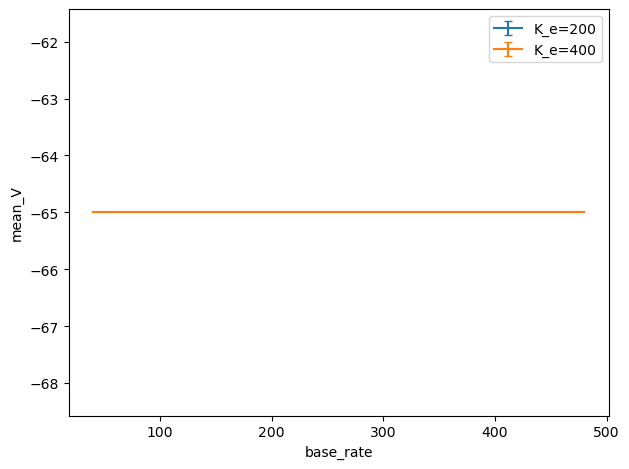

/var/folders/mb/f1_g1g0n1s13vfylsby2v1bm0000gn/T/ipykernel_56307/2702369881.py:107: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/wyc/opt/miniconda3/envs/standard/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


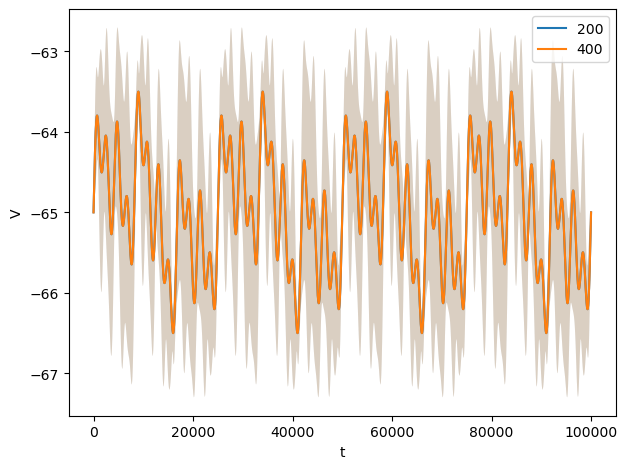

In [21]:
plot_xy(trials, {"K_i": 50}, x="base_rate", y="mean_V", l="K_e")
plot_tv(trials, {"K_i": 50}, t_key="t", v_key="V", l="K_e")
plt.show()

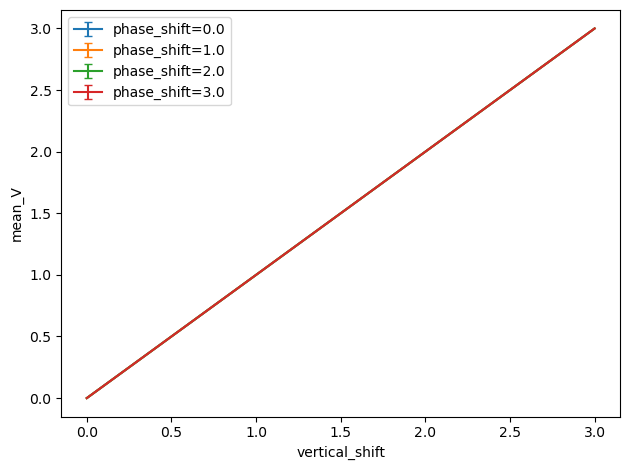

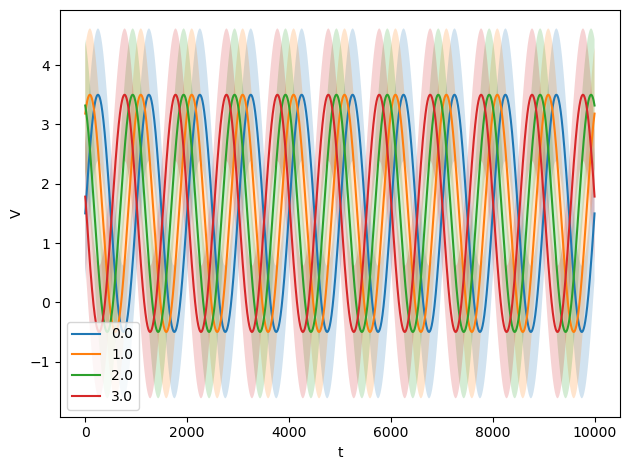

In [25]:
trials = collect_data("../outputs/sin/20251009-235725-6Ju8xeob")
plot_xy(trials, {}, x="vertical_shift", y="mean_V", l="phase_shift")
plot_tv(trials, {}, t_key="t", v_key="V", l="phase_shift")
plt.show()